In [1]:
# Clear workspace
rm(list = ls())
# Load libraries
library(tidyverse)
library(RColorBrewer)
library(igraph)
library(igraphdata)
library(corrplot)
# setup things
theme_set(theme_light())
my_palette <- colorRampPalette(brewer.pal(n = 9, name = "PuBuGn"))(51)[2:51] # remove white
igraph_options(vertex.color = "aquamarine3", vertex.frame.color = "white", vertex.frame.size = 1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

corrplot 0.84 loaded


# Networks: A very brief Introduction

What we have seen yesterday:

1. Fundamentals of Graph Theory
2. How to 
    * build `igraph` graph objects,
    * plot them with some customisation
    * get their characterising matrices - adjacency matrix $A$, and (normalised) Laplacian **L**
    * compute the degree of each vertex, the degree distribution and to plot the latter
    * generate synthetic networks (ER, Barabasi-Albert)

## Network Models

### 1. Random graph model

The simplest network model is the random graph due to Erdos and Renyi, [Erdos and Renyi (1959)](http://www.leonidzhukov.net/hse/2016/networks/papers/erdos-1959-11.pdf) and it is often indicated by their names.

In the Erdos-Renyi model (ER) some parameters have fixed values while the network is otherwise random.
Fixing the number $N$ of vertices and $m$ of edges and placing the edges randomly one gets $G(N, m)$.
Typically, no self- or multi-deges are allowed, i.e. $G(N, m)$ is a simple graph.

The rigorous definition is the following
> **ER Random Graph**
  Consider the ensemble $\Omega$ of all possible graphs with $N$ labelled vertices $v_1, \dots, v_N$ and $m$ edges.
  A random graph $G(N, m)$ is an element of $\Omega$ selected with uniform probability $P(G) = \frac{1}{|\Omega|}$.

$|\Omega|$ is derived by simple combinatorics:

* for a graph $G=(V, E)$ having $m$ edges means that $|E|=m$, 
* $E \subseteq V \times V$ and $|V \times V|=\binom{N}{2}=\frac{N(N-1)}{2}$.

The size of $\Omega$ is then the number of subsets of size $m$ of a set of size $\binom{N}{2}$, that is $\binom{\binom{N}{2}}{m}$.

In [2]:
N <- 100
N*(N-1)/2

[1] 4950

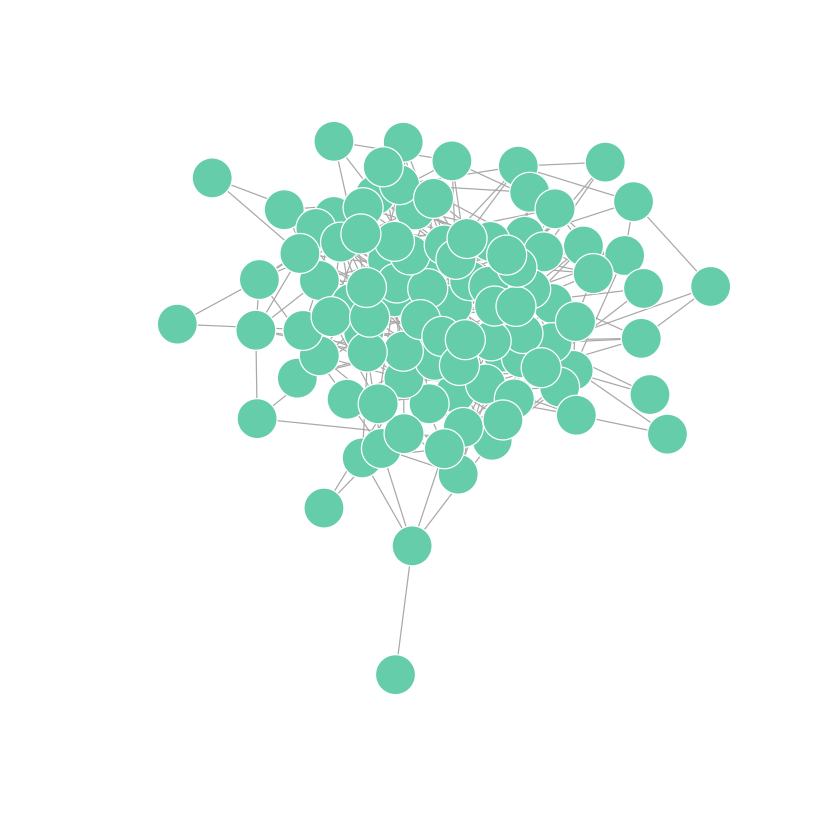

In [3]:
m <- 345
g <- sample_gnm(n = N, m = m)
plot(g, vertex.label = NA)

## Network Properties

If a graph is connected the geodesic or shortest-path distance $d_{i, j} = d_{sp}(v_i, v_j)$ is the length of a shortest path connecting $v_i$ and $v_j$.

The shortest-path distance matrix $D_{sp}$ can be computed using `igraph::distances`

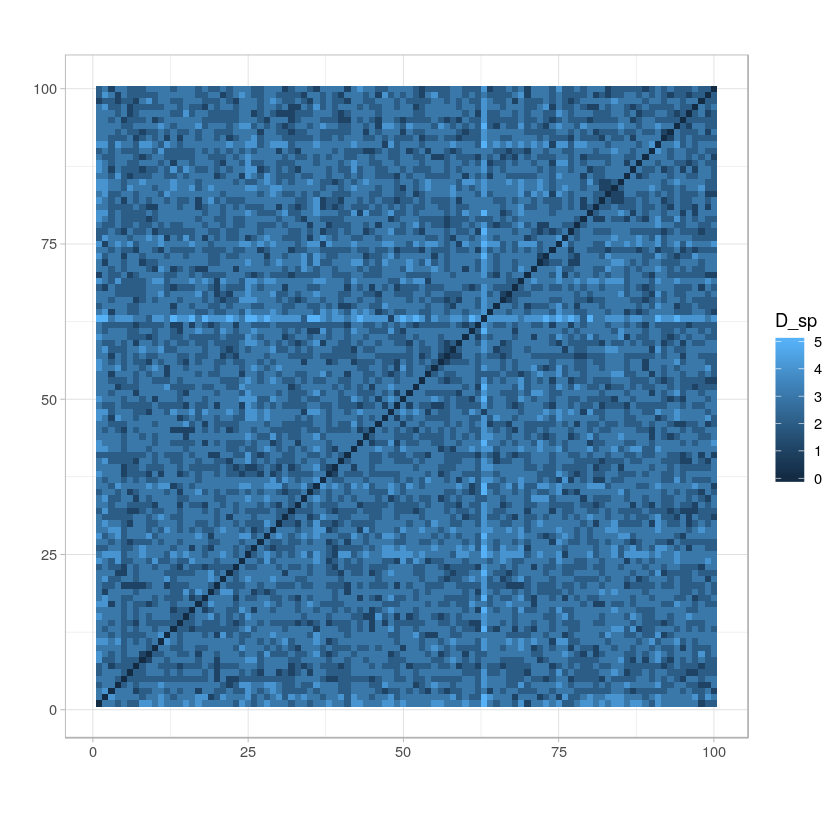

In [4]:
D_sp <- distances(graph = g)
colnames(D_sp) <- 1:N
as_tibble(D_sp) %>% 
  add_column("node" = 1:N, .before = 1) %>%
  gather(key, value, -node) %>%
  mutate(key = as.integer(key)) %>%
  ggplot(aes(x = node, y = key, fill = value)) +
    geom_tile() +
    coord_equal() +
    labs(x = "", y = "", fill = "D_sp")

The **diameter** of a graph is the length of the longest geodesic (shortest-path), i.e. $diam(G) = \max_{i, j} d_{ij}$.

In [5]:
diameter(g)

[1] 5

In [6]:
get.diameter(g)

+ 6/100 vertices, from b221e7d:
[1]  1 70 90 54 48 63

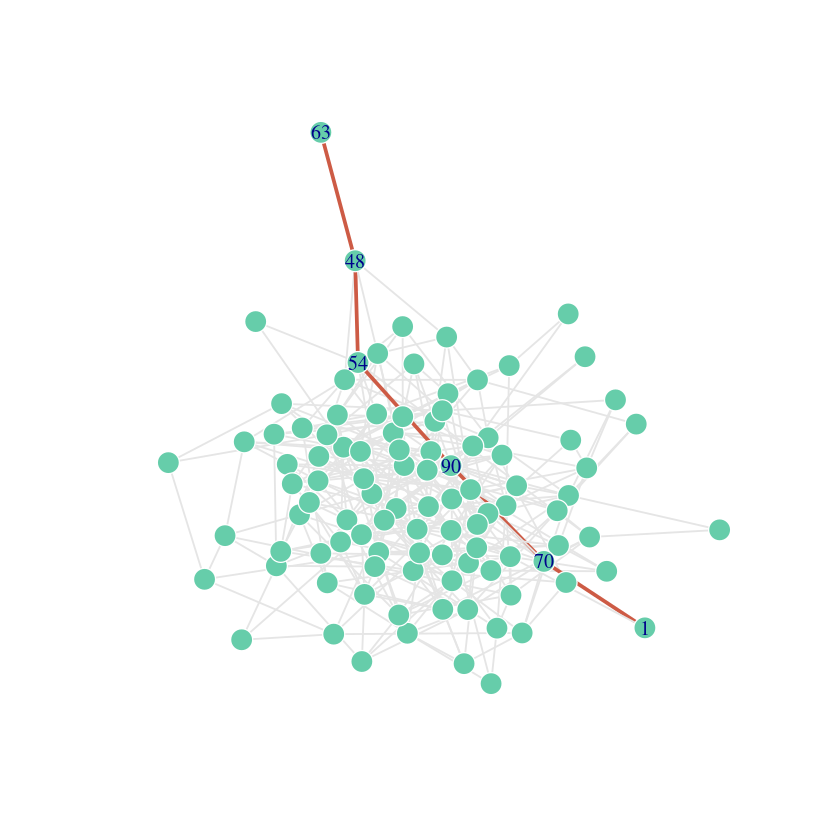

In [7]:
V(g)$label <- V(g)
V(g)$label[!(V(g) %in% get.diameter(g))] <- NA
E(g)$color <- "#e5e5e5"
E(g, path = get.diameter(g))$color <- "coral3"
E(g)$width <- 1.5
E(g, path = get.diameter(g))$width <- 3
plot(g, vertex.size = 8)

#### Average shortest-path

We can compute the averege geodesic length as $$\langle l \rangle = \frac{1}{N(N-1)} \sum_{i\neq j} d_{ij}.$$

The **small-world effect** refers to the fact that in many real networks the typical geodesic distance is surprisingly short, in particular when compared with the number of nodes of the network.

See Milgram's small-world experiment (1967) and six degree of separation.

In [8]:
sum(D_sp)/N/(N-1)

[1] 2.598788

Average degree $$\langle k \rangle = \frac{1}{N} \sum_i k_i = \sum_k k p_k = \frac{2|E|}{|V|} = \frac{2m}{N}$$

In [9]:
avg_k <- 2*m/N
avg_k

[1] 6.9

In [10]:
mean(degree(g))

[1] 6.9

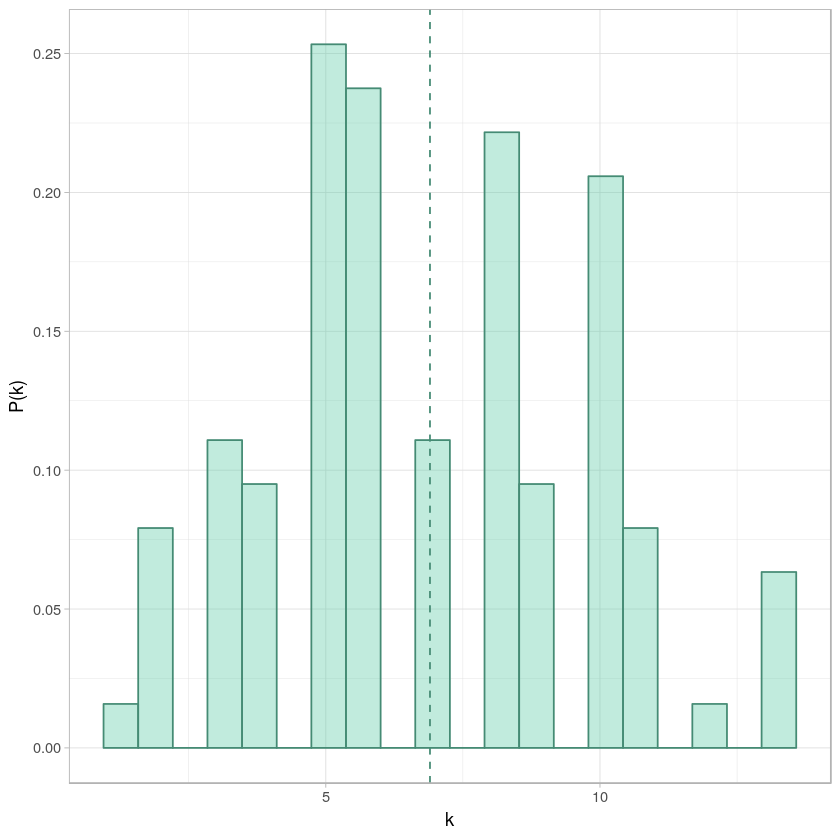

In [11]:
ggplot(data.frame("k" = degree(g)), aes(k)) +
  geom_histogram(aes(y = ..density..), bins = 20, color = "aquamarine4", fill = "aquamarine3", alpha = .4) +
  geom_vline(aes(xintercept = mean(k)), color = "aquamarine4", linetype = "dashed") +
  labs(x = "k", y = "P(k)")

### Gilbert Random Graph

Given $N$ nodes each edge has the same probability $p$ of being included in the graph, independently from the others.

Let $\{G(N, p)\}$ be the ensemble of graphs with $N$ vertices, connection probability 
$$p = P\left(\{i, j\} \in E\right) \quad \forall i, j, \in 1, \dots, N$$ then a particular graph $G$ is selected with probability
\begin{equation}
P(G) = p^m (1-p)^{\binom{N}{2} - m}.
\end{equation}
where $m$ is the number of edges. 

Observe that if $p=0.5$ previous equation becomes
\begin{equation}
P(G) = p^m (1-p)^{\binom{N}{2} - m} = p^{\binom{N}{2}}
\end{equation}
and all graphs with $N$ nodes can be chosen with the same probability.

#### Distribution of edges in the model

The number of graphs with exactly $N$ nodes and $m$ vertices:

1. $\binom{N}{2}$ number of pairs of vertices
2. how many ways to choose $m$ elements (edges) from a set of $\binom{N}{2}$ elements $\longrightarrow$ combinations! $\binom{\binom{N}{2}}{m}$

Then the probability of drawing from the ensemble $\{G(N, p)\}$ a graph with $m$ edges is
$$P(m) = \binom{\binom{N}{2}}{m} P(G) = \binom{\binom{N}{2}}{m} p^m (1-p)^{\binom{N}{2} - m}.$$

$G(N, p)$ is also called "Bernoulli random graph" for this reason.

#### Average Degree

We saw that $\langle k \rangle = \frac{2m}{N}$. Thus, in case of $G(N, m)$ we have
$$
\begin{aligned}
\langle k \rangle & = \sum_{m = 0}^{\binom{N}{2}} \frac{2m}{N} P(m) \\
& = \frac{2}{N} \sum_{m = 0}^{\binom{N}{2}} m P(m) \\
& = \frac{2}{N} \langle m \rangle = (N-1) p.
\end{aligned}
$$

#### Degree distribution

* The probability of vertex $i$ having exactly degree $k$ is $p^k (1-p)^{N-1-k}$ 
* there are $\binom{N-1}{k}$ possible ways to select the $k$ nodes $i$ is linked to, hence

$$P(k) = \binom{N-1}{k} p^k (1-p)^{N-1-k}$$

#### Poisson approximation

For large networks the expected degree is approximately constant $c = (N-1)p$ and so in the limit for $N \to \infty$ $p = \frac{c}{N-1} \to 0$. We know from probability theory that the binomial distribution can be approximated with a Poisson with parameter $c$. $G(N, p)$ is also called Poisson random graph for this reason.

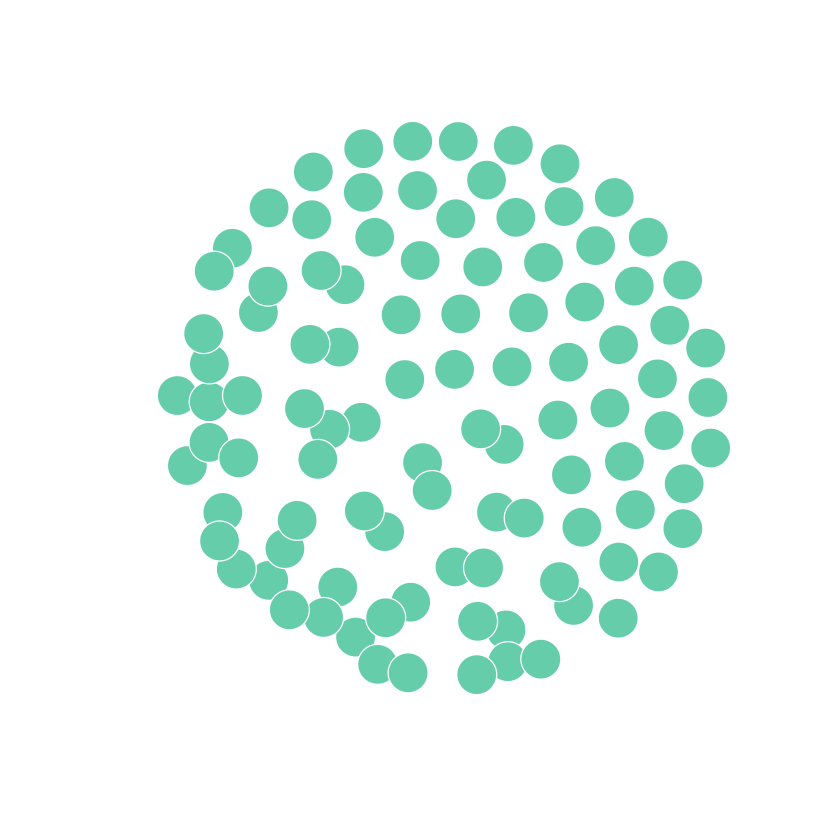

In [12]:
g <- sample_gnp(n = N, p = .008)
plot(g, vertex.label = NA)

If the expected degree is less than 1, then we cannot expect the graph to be connected!

In [13]:
N*.008

[1] 0.8

If $Np > 1$ the graph is almost surely connected.

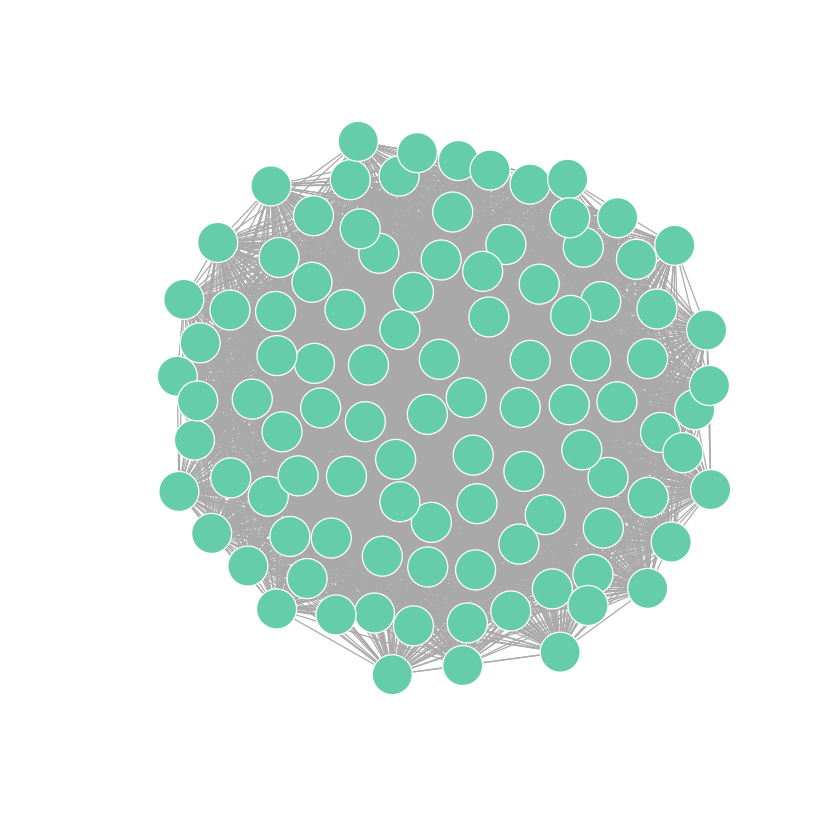

In [14]:
g <- sample_gnp(n = N, p = .8)
plot(g, vertex.label = NA)

### 2. Scale-free model

Network with a power-law degree distribution
$$P(k) \propto k^{-\alpha}$$
are called scale-free.

In these type of networks it has **no sense to speak about the "average behaviour"**: in a a power-law degree-distribution, i.e. a distribution with fat tail, the possible degrees are not concentrated around the mean! 

Observe that the first moment (expected degree) exists only if $1 < \alpha$. Typically in empirical networks $2 \leq \alpha \leq 3$.

#### The Barabasi-Albert model: Growth and preferential attachment

* **GROWTH**: in real networks the number of nodes continually grows thanks to the addition of new nodes
* in most real networks new nodes prefer to link to the more connected nodes, a process called **preferential attachment** (rich-gets-richer phenomenon)

#### Reference Papers

[BARABÁSI, A.-L., & BONABEAU, E. (2003). Scale-Free Networks. Scientific American. Scientific American, a division of Nature America, Inc.](https://doi.org/10.2307/26060284)

[Clauset, A., Shalizi, C. R., & Newman, M. E. J. (2009). Power-Law Distributions in Empirical Data. SIAM Review, 51(4), 661–703.](https://doi.org/10.1137/070710111)

[Broido, A. D., & Clauset, A. (2018). Scale-free networks are rare.](http://arxiv.org/abs/1801.03400)

[Barabasi, Network Science - Ch. 5](http://barabasi.com/f/622.pdf)

In [15]:
g <- ba.game(n = 1000, directed = F)

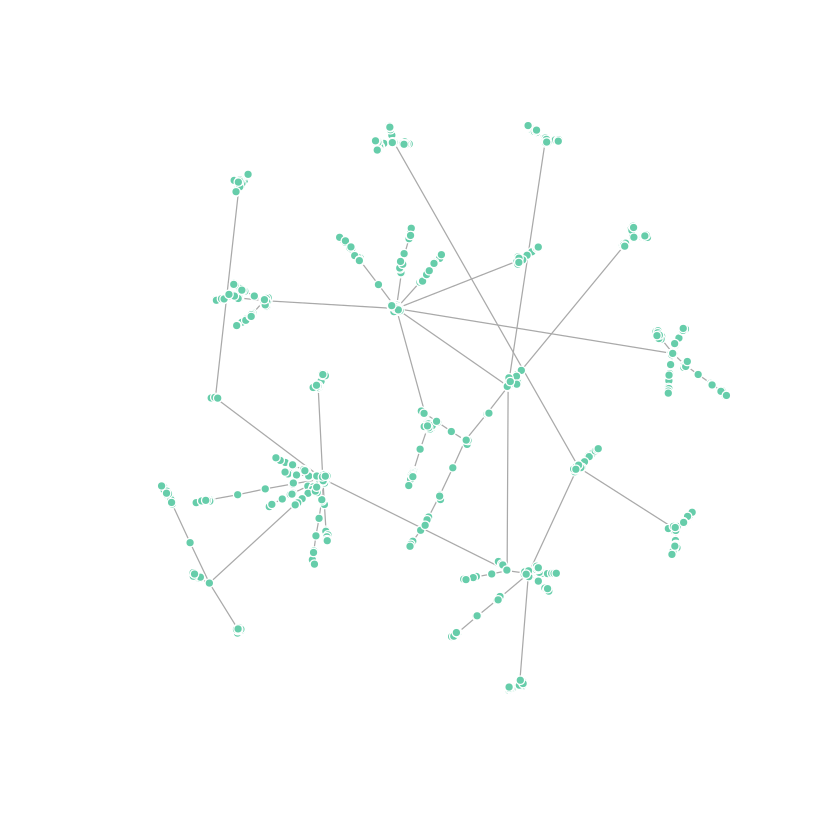

In [16]:
plot(g, vertex.label = NA, vertex.size = 3)

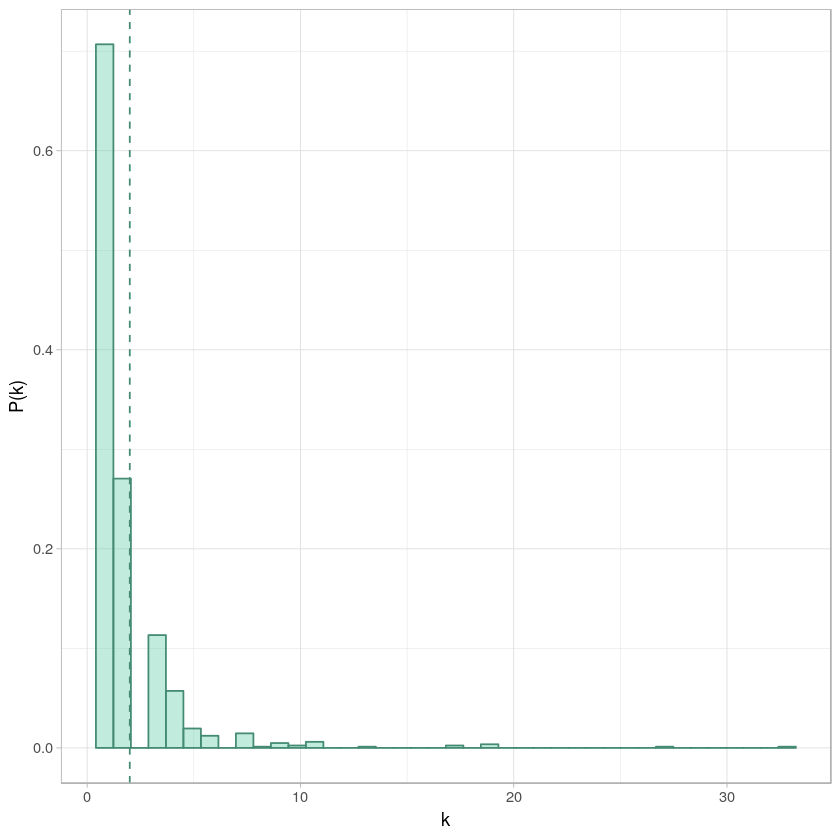

In [17]:
ggplot(data.frame("k" = degree(g)), aes(k)) +
  geom_histogram(aes(y = ..density..), bins = 40, color = "aquamarine4", fill = "aquamarine3", alpha = .4) +
  geom_vline(aes(xintercept = mean(k)), color = "aquamarine4", linetype = "dashed") +
  labs(x = "k", y = "P(k)")

There are a lot (i.e. more than 75%) of nodes with just one neighbour, but there are also some nodes with very high degree (w.r.t. the others).

### US Airport network

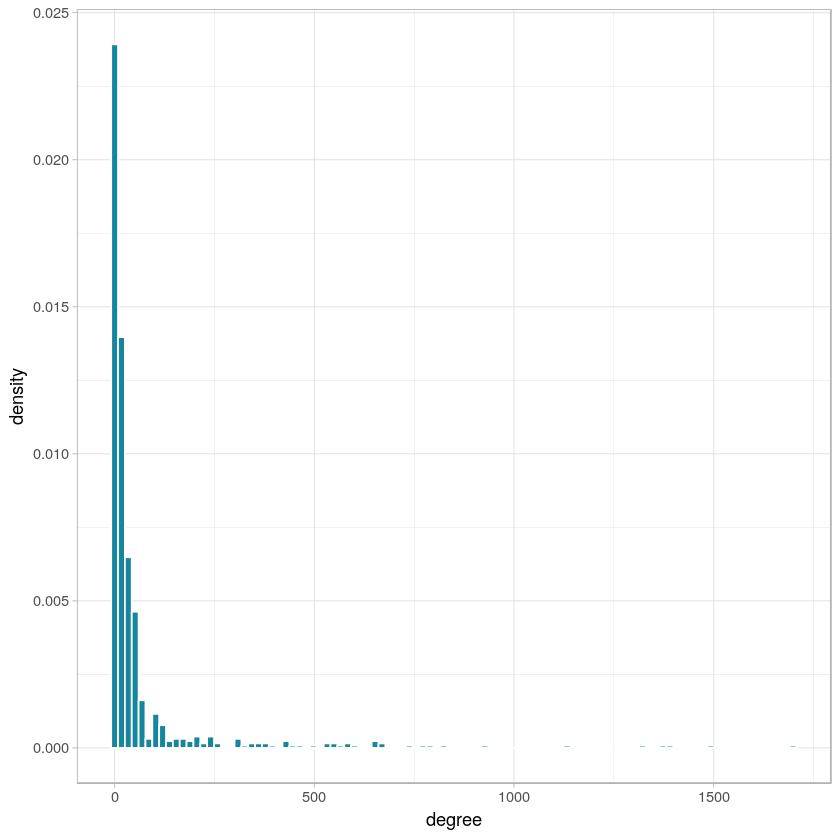

In [18]:
data(USairports)
ggplot(data.frame(degree = degree(USairports)), aes(degree)) + 
  geom_histogram(aes(y = ..density..), bins = 100, fill = my_palette[35], color = "white")

In [19]:
us_comps <- components(USairports)
us_g <- induced_subgraph(USairports, V(USairports)[us_comps$membership == which.max(us_comps$csize)])
us_lay <- layout_with_fr(us_g)
us_deg <- degree(us_g)

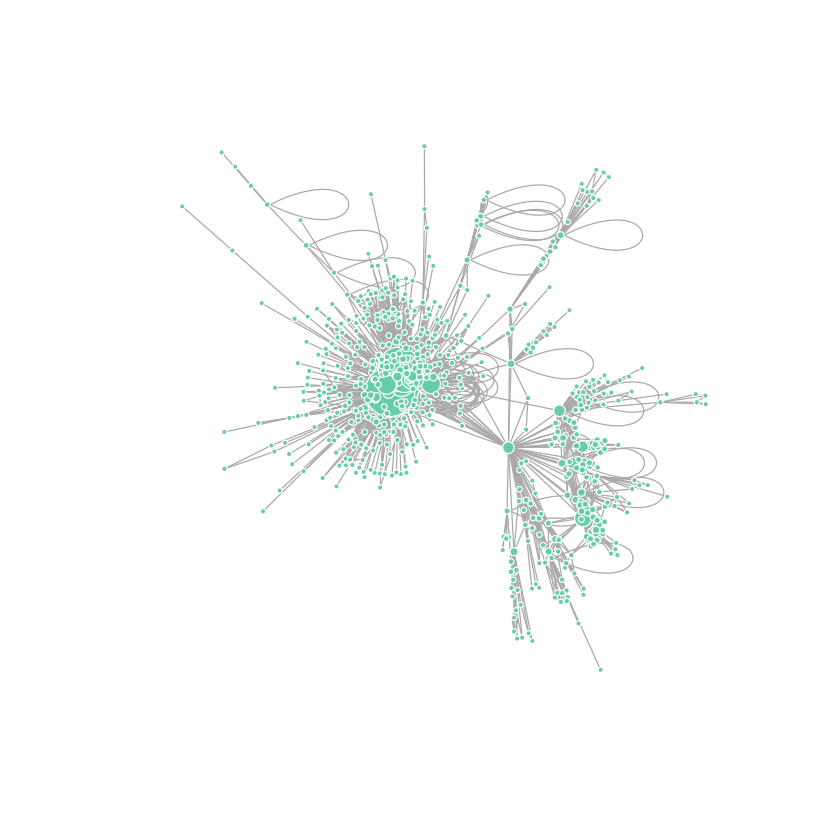

In [20]:
plot(as.undirected(us_g), layout = us_lay, vertex.label = NA, vertex.size = 2 + .01*us_deg)

#### Other network models
* Small-world model
* _Generative network models_, they model the mechanisms by which networks are created.
* The _configuration model_ takes as input an exact sequence of degrees and creates a random graph with that degree sequence.

See Chapter 14 of _Newman - Networks: An Introduction_, for further reference.

## Centrality measures

* Fundamental concept in network analysis: _which is the most important node?_
* First developments by social scientists Bavelas (1948, 1950), Leavitt (1951), Bonacich (1972)
* Definition of _importance_?
* [In 1978 Freeman](https://goo.gl/8j4z9Y), a mathematical social scientist, categorises existing centrality measures in three groups, whose more representative measures are 
    * degree,
    * closeness,
    * betweenness.
* [Borgatti, S. P., & Everett, M. G. (2006). A graph-theoretic perspective on centrality. Social networks, 28(4), 466-484.](https://doi.org/10.1016/j.socnet.2005.11.005).

In the next section we are going to see the definitions of common centralities, how to compute them using `igraph` and we will compare them on toy models.

### 2.1 Cenrality Measures

#### Degree

$k_i$, the degree of vertex $i$, can be seen as a measure of its importance inside the network, indeed $i$ receives a centrality point for each and everyone of its neighbours; the more connections, the highest $i$'s centrality.

In case of directed networks one has to distinguish between \textit{in-} and \textit{out-degree}.
For instance, a scientific paper is evaluated by the number of citations it receives, i.e. its out-degree in the citation network.

In [21]:
data(UKfaculty)
UKfaculty

IGRAPH 6f42903 D-W- 81 817 -- 
+ attr: Type (g/c), Date (g/c), Citation (g/c), Author (g/c), Group
| (v/n), weight (e/n)
+ edges from 6f42903:
 [1] 57->52 76->42 12->69 43->34 28->47 58->51  7->29 40->71  5->37 48->55
[11]  6->58 21-> 8 28->69 43->21 67->58 65->42  5->67 52->75 37->64  4->36
[21] 12->49 19->46 37-> 9 74->36 62-> 1 15-> 2 72->49 46->62  2->29 40->12
[31] 22->29 71->69  4-> 3 37->69  5-> 6 77->13 23->49 52->35 20->14 62->70
[41] 34->35 76->72  7->42 37->42 51->80 38->45 62->64 36->53 62->77 17->61
[51]  7->68 46->29 44->53 18->58 12->16 72->42 52->32 58->21 38->17 15->51
[61] 22-> 7 22->69  5->13 29-> 2 77->12 37->35 18->46 10->71 22->47 20->19
+ ... omitted several edges

In [22]:
edge_density(UKfaculty)

[1] 0.1260802

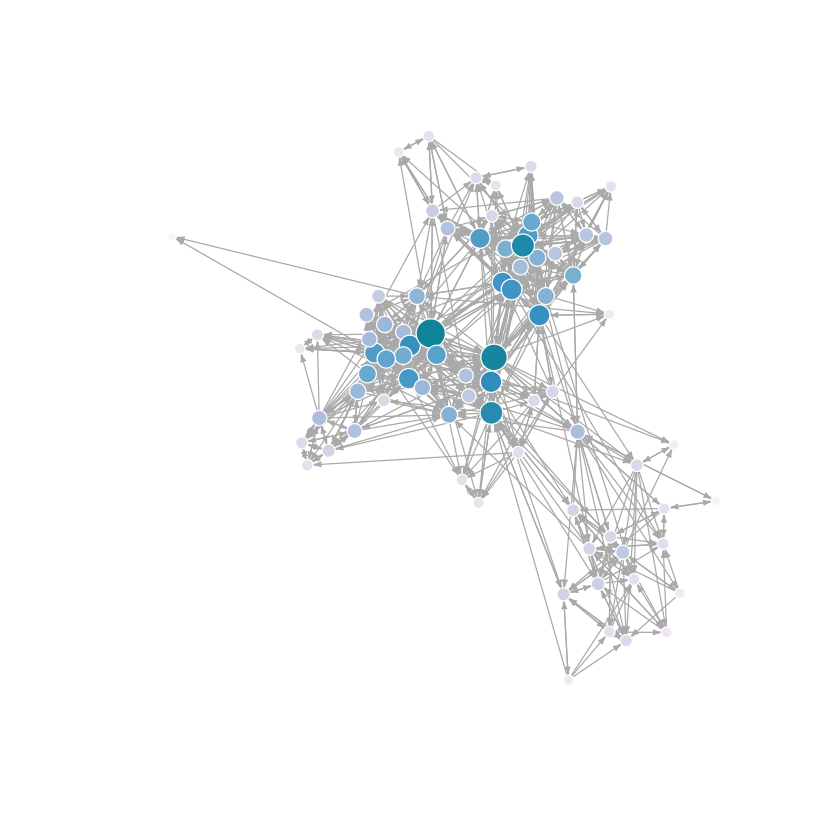

In [23]:
degC <- degree(UKfaculty, normalized = T)
uk_lay <- layout_nicely(UKfaculty)
plot(UKfaculty, layout = uk_lay, vertex.label = NA,vertex.size = 3 + 10*degC,
     vertex.color = my_palette[as.factor(degC)], edge.arrow.size = 0.3)

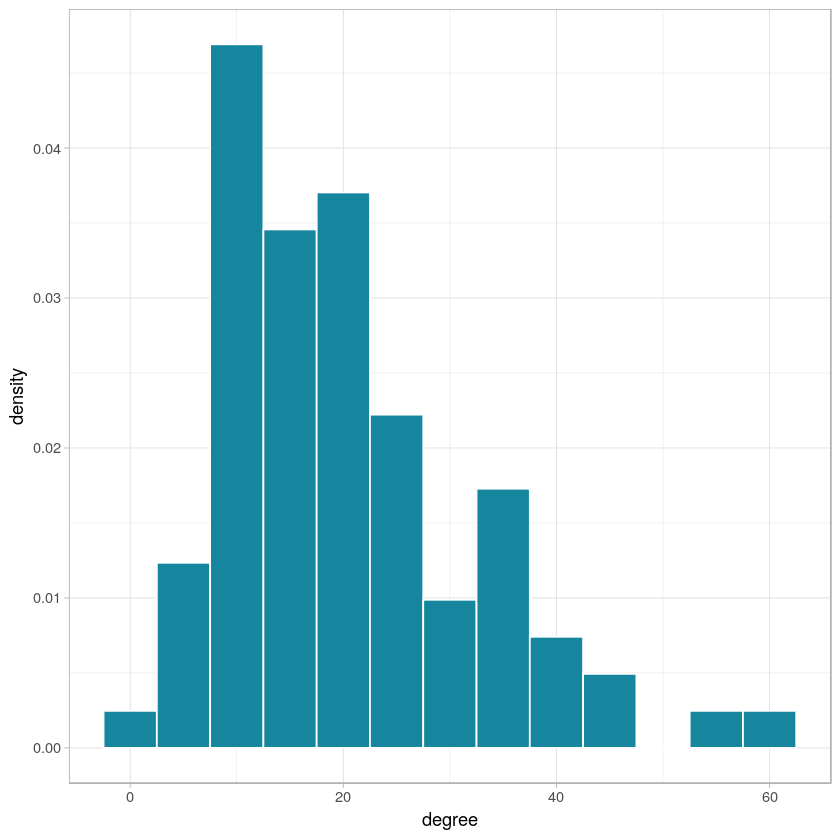

In [24]:
ggplot(data.frame(degree = degree(UKfaculty)), aes(degree)) + 
  geom_histogram(aes(y = ..density..), binwidth = 5, fill = my_palette[35], color = "white")

The degree is a very local centrality measure, for instance if 

---

#### Closeness 
The measures seen until now are all based on the degree and the degree of a vertex is viewed as important as an index of its potential communication activity.

The closeness is based a different intuitive conception of centrality, that is the degree to which a point is _close to_ all other points in the graph.
In order to say what "close" means, a definition of distance is needed and the natural choice is the shortest path distance.

Mathematically, closeness centrality measures the mean geodesic distance from a point to other vertices.
Given $D = \{d_{ij}\}$ the shortest path distance matrix, the mean distance $l_i$ is
\begin{equation*}
  l_i = \frac1N \sum_{j} d_{ij}.
\end{equation*}
This is a measure of outlyingness since it takes a low value when the terms $d_{ij}$ are small, i.e. $i$ is separated from other vertices by short geodesics.
Hence, the closeness centrality of vertex $i$ is defined as
\begin{equation}
  C_i = \frac{1}{l_i} = \frac{N}{\sum_{j} d_{ij}} \label{eq:cloC}
\end{equation}

In [25]:
summary(closeness(UKfaculty))
cloC <- closeness(UKfaculty, normalized = T)

Warning message in closeness(UKfaculty):
“At centrality.c:2617 :closeness centrality is not well-defined for disconnected graphs”

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001543 0.0019763 0.0025575 0.0025473 0.0030120 0.0046512 

Warning message in closeness(UKfaculty, normalized = T):
“At centrality.c:2617 :closeness centrality is not well-defined for disconnected graphs”

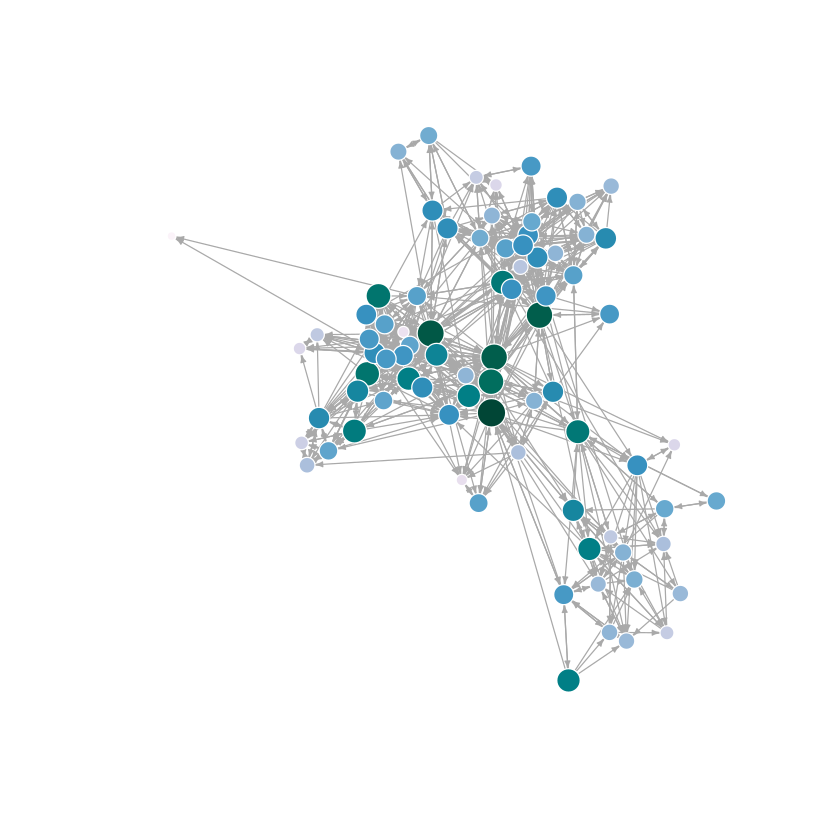

In [26]:
plot(UKfaculty, layout = uk_lay, vertex.label = NA, vertex.size = 3 + 20*cloC,
     vertex.color = my_palette[cut(as.numeric(cloC), breaks = 50)], 
     edge.arrow.size = 0.3)

#### Betweenness Centrality
A third view of node centrality is based upon the frequency with which a point falls between pairs of other nodes on the shortest paths connecting them.
Again the idea comes from social sciences, where a person strategically located on the communication paths linking pairs of others is central, since she/he can influence the group controlling the information flow [Freeman (1978)](https://doi.org/10.1016/0378-8733(78)90021-7).

Newman explains the concept very clearly

>  Suppose we have a network with something flowing around it. [...] Let us initially make the assumption that every connected pair of vertices in the network exchanges a message with equal probability per unit time and that massages always take the shortest path (or one such paths, if more exist). [...] After a suitably long time, how many massages, on average, will have passed through each vertex en route to their destination? - Newman (2010)

The rate at which messages flow through geodesic paths is constant, so the number of messages passing trough each vertex is proportional to the number of geodesics the vertex lies on, that is its betweenness centrality.

Let $i, s, t \in V$, $n_{st}(i) = 1$ if $i$ lies on the shortest path between $s$ and $t$.
Then
\begin{equation}
  x_i = \sum_{s, t} n_{st} (i). 
\end{equation}
Observe that in an undirected network the geodesic path from $s$ to $t$ is the same as the one $t \to s$, so the centrality $x_i$ is essentially counting the paths twice.
Usually one is interested only in the relative magnitude of the centralities, so it is not mandatory to divide $x_i$ by two.

Further one has also to define $n_{st}(s)$ and $n_{st}(t)$, whether $s$ and $t$ lie on the path between $s$ and $t$.
Excluding them ($n_{st}(s)=0$) only reduces the betweenness value by twice the size of the component to which the vertex belongs, so the ranking inside the component remains unchanged.

The rankings of nodes in different components may change, though it is rarely a problem, as betweenness is usually not used to compare vertices in different components - intuitively, those vertices compete for different areas of influence.

Finally, in case of more than one shortest path connecting nodes $s$ and $t$, a small correction has to be introduced
\begin{equation}
  x_i = \sum_{s, t} \frac{n_{st} (i)}{g_{st}(i)}
\end{equation}
where $g_{st}(i)$ is the total number of geodesic paths from $s$ to $t$.

In [27]:
summary(betweenness(UKfaculty))
btwC <- betweenness(UKfaculty, normalized = T)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    7.333   90.248  177.287  260.070 1223.084 

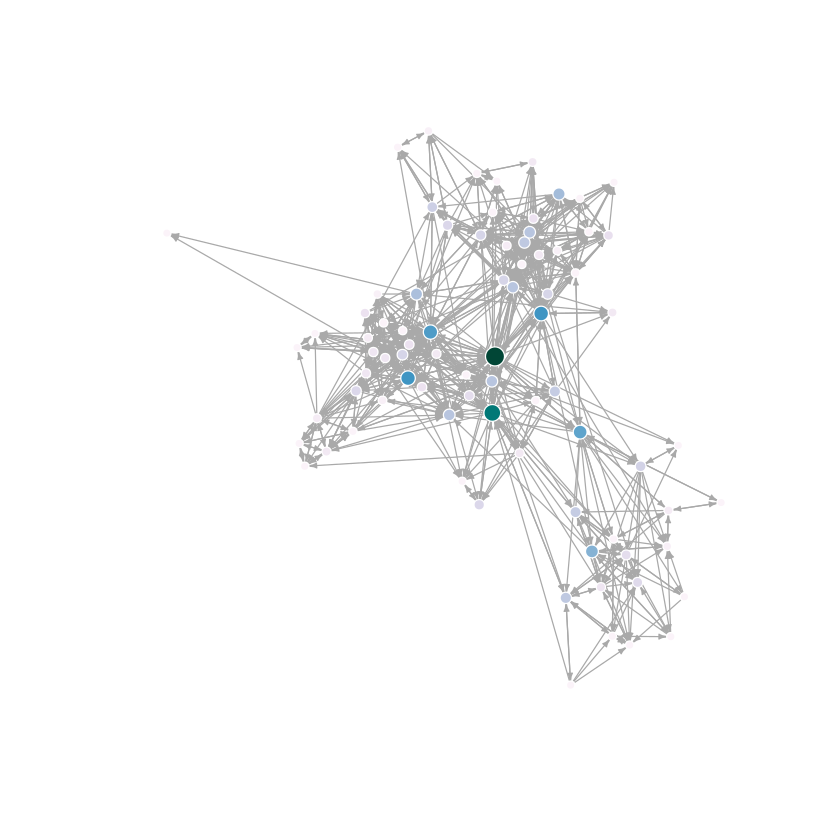

In [28]:
plot(UKfaculty, layout = uk_lay, vertex.label = NA, 
     vertex.size = 3 + 20*btwC,
     vertex.color = my_palette[cut(as.numeric(btwC), breaks = 50)], 
     edge.arrow.size = 0.3)

* Computing the betweenness is very time consuming since one has to compute all shortest-paths between any pairs of nodes
* many algorithms for the betweenness computation have been proposed (based on breadth first search or on subset of graphs - i.e. approximations of btw)

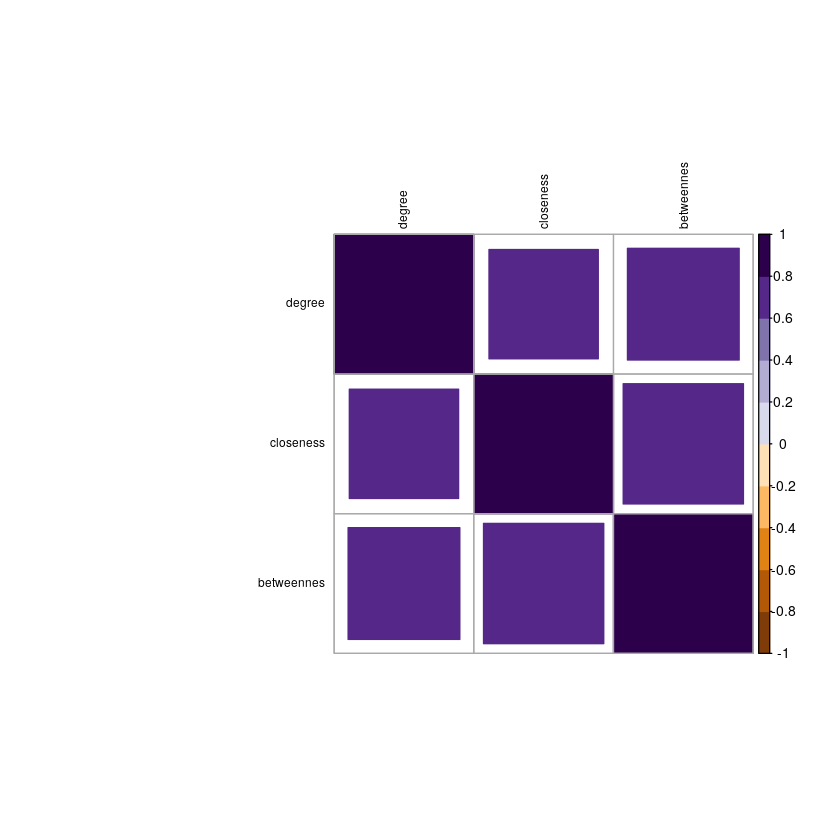

In [29]:
cor_dd <- list("degree" = degC, "closeness" = cloC, "betweennes" = btwC)
cor_dd <- cor(as.data.frame(cor_dd), method = "spearman")
corrplot(cor_dd, method = "square",
         outline = F, addgrid.col = "darkgray", order = "hclust",
         mar = c(3, 3, 3, 1),
         tl.col = "black", tl.cex = .6, cl.cex = .7,
         col = brewer.pal(n = 10, name = "PuOr"))

### Spearman's Rank Correlations

Two-sided test on Spearman’s rank correlation coefficients.

#### Reference
M. Hollander, D. A. Wolfe, and E. Chicken. Nonparametric statistical methods, volume 751. John
Wiley & Sons, 2013

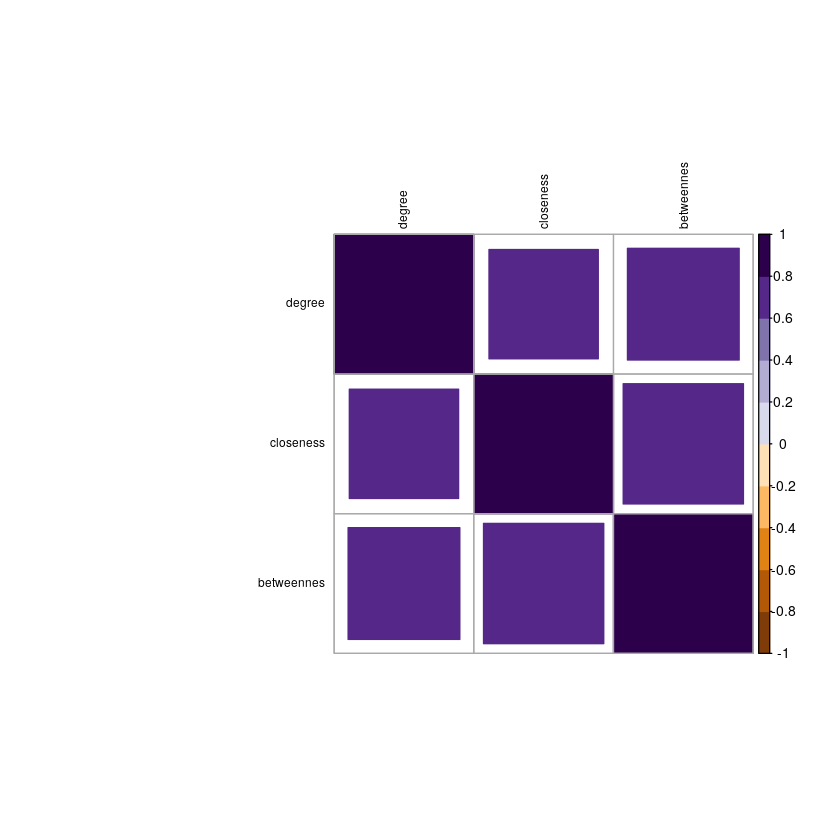

In [30]:
library(SuppDists)
lt_corrm2 <- cor_dd[lower.tri(cor_dd)]
n <- dim(cor_dd)[1]
lt_pSp2 <- 2*pSpearman(q = -lt_corrm2, r = N)
pSp2 <- matrix(rep(0, n*n), nrow = n)
pSp2[lower.tri(pSp2)] <- lt_pSp2
pSp2[upper.tri(pSp2)] <- t(pSp2)[upper.tri(t(pSp2))]
corrplot(cor_dd, method = "square",
         outline = F, addgrid.col = "darkgray", order = "hclust",
         mar = c(3, 3, 3, 1),
         tl.col = "black", tl.cex = .6, cl.cex = .7,
         col = brewer.pal(n = 10, name = "PuOr"),
         p.mat = pSp2, sig.level = 0.05, pch.cex = .7, pch.col = "white")

#### PageRank

Algorithm used by Google Search to rank web pages in their search engine results, named after Larry Page.

[The PageRank Citation Ranking: Bringing Order to the Web.](http://ilpubs.stanford.edu:8090/422/)

It is very similar to eigenvector and Katz centrality. It is a radial, volume centrality measure.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002525 0.007745 0.011240 0.012346 0.014538 0.030504 

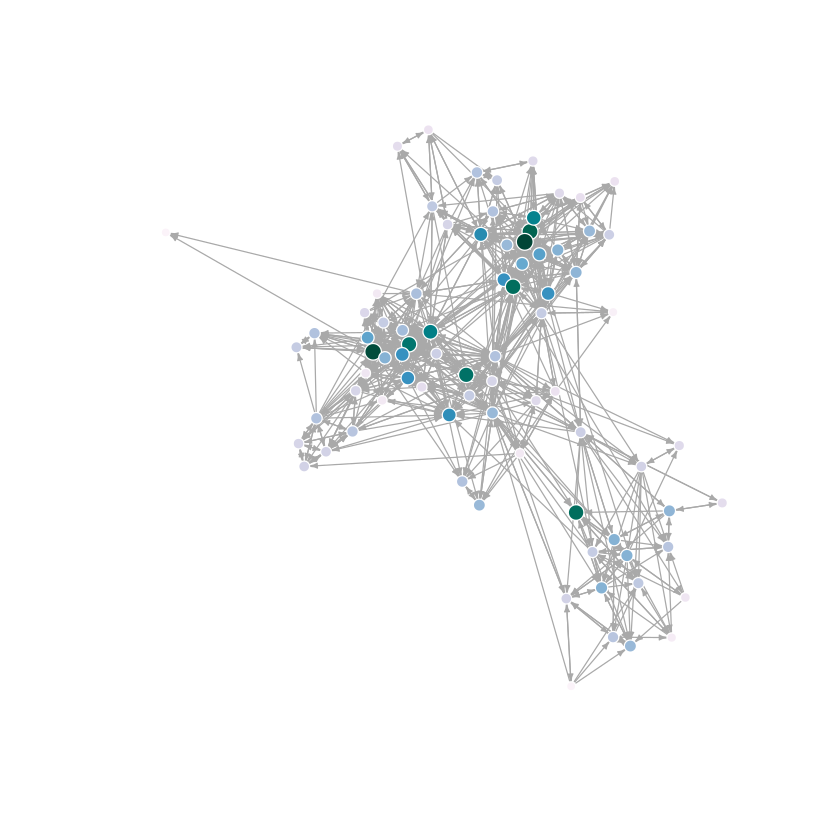

In [31]:
summary(page_rank(UKfaculty)$vector)
pgR <- page_rank(UKfaculty)$vector
plot(UKfaculty, layout = uk_lay, vertex.label = NA, 
     vertex.size = 3 + 100*pgR,
     vertex.color = my_palette[cut(as.numeric(pgR), breaks = 50)], 
     edge.arrow.size = 0.3)

In [32]:
eigC <- eigen_centrality(UKfaculty)$vector

In [33]:
cor_dd <- list("degree" = degC, "closeness" = cloC, "betweennes" = btwC, 
               "pgR" = pgR, "eigen" = eigC)
cor_dd <- cor(as.data.frame(cor_dd), method = "spearman")
# corrplot(cor_dd, method = "square",
#          outline = F, addgrid.col = "darkgray", order = "hclust",
#          mar = c(3, 3, 3, 1),
#          tl.col = "black", tl.cex = .6, cl.cex = .7,
#          col = brewer.pal(n = 10, name = "PuOr")) 

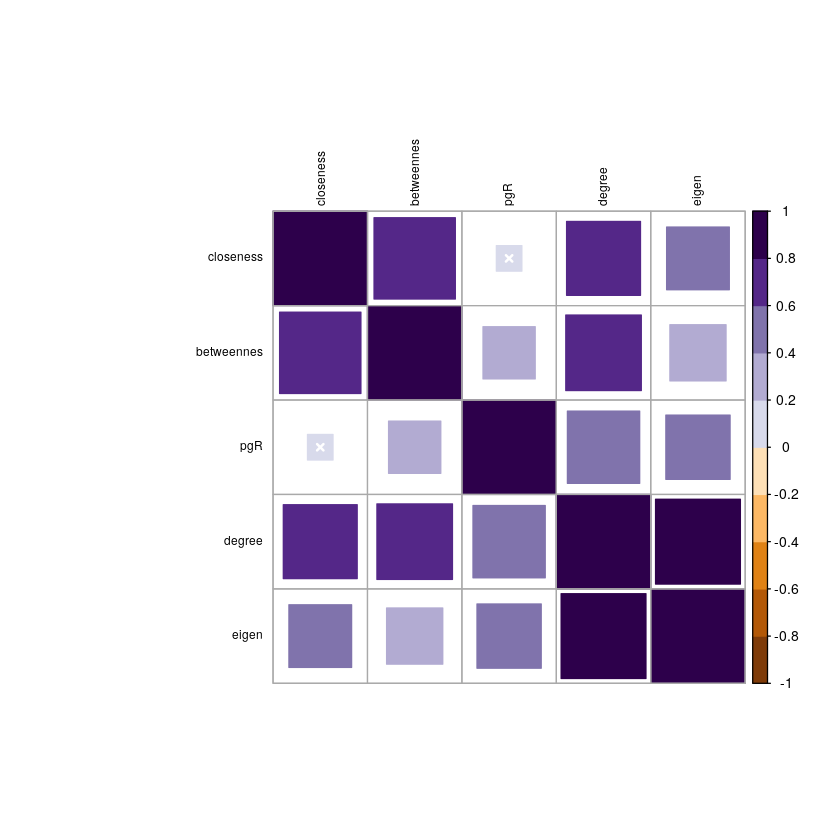

In [34]:
lt_corrm2 <- cor_dd[lower.tri(cor_dd)]
n <- dim(cor_dd)[1]
lt_pSp2 <- 2*pSpearman(q = -lt_corrm2, r = N)
pSp2 <- matrix(rep(0, n*n), nrow = n)
pSp2[lower.tri(pSp2)] <- lt_pSp2
pSp2[upper.tri(pSp2)] <- t(pSp2)[upper.tri(t(pSp2))]
corrplot(cor_dd, method = "square",
         outline = F, addgrid.col = "darkgray", order = "hclust",
         mar = c(3, 3, 3, 1),
         tl.col = "black", tl.cex = .6, cl.cex = .7,
         col = brewer.pal(n = 10, name = "PuOr"),
         p.mat = pSp2, sig.level = 0.05, pch.cex = .7, pch.col = "white")

### Other centralities

* Katz centrality
* Hubs and Authorities
* random walk and flow betweenness
* Estrada's subgraph centrality
* ...

### References

[Borgatti, S. P., & Everett, M. G. (2006). A Graph-theoretic perspective on centrality. Social Networks, 28(4), 466–484.](https://doi.org/10.1016/J.SOCNET.2005.11.005)

---

Until now we have seen some macroscale properties of networks (degree distribution, diameter, average degree) and microscale properties, i.e. at node level, e.g. centralities.

Let us take a quick look at the mesoscale structure of the graph, through community detection. There are other mesoscale structures of interest:

* core-periphery structure [P. Rombach, M. Porter et al. (2017)](https://doi.org/10.1137/17M1130046)
* rich-club [The rich-club phenomenon in the Internet topology - S. Zhou, R. J. Mondragón (2004)](https://arxiv.org/pdf/cs/0308036.pdf)

## 3. Community detection

What is a community, how can we define a group?

Many real networks display a community structure, vertices are organised into groups: groups of friends in a social network, groups of related web pages in the WWW, groups of proteins in an interactome (protein-protein interaction network).

There is not a clear definition of community, so let us start from some **measures of clustering**.

Take three guys "a", "b" and "c". If "a is friend with b" and "b is a friend with c" then with high probability also "c is friend with a". So that $\{a, b, c\}$ form a triangle (a clique with 3 nodes, $K_3$).

In [35]:
tri_g <- make_graph(edges = c("a", "b", "b", "c"), directed = F)

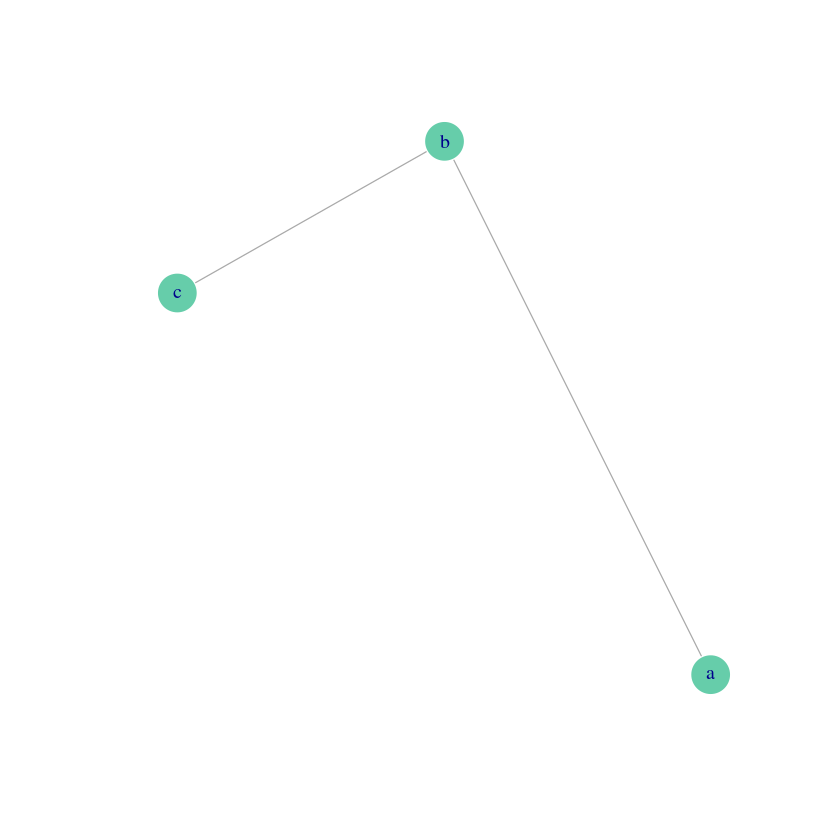

In [36]:
plot(tri_g)

_abc_, that is $\{(a, b), (b, c)\}$, is a path of length 2 - remember that a path is a sequence of non-repeating edges. If there is also the edge $(c, a)$ then we have a _closed path_ or a loop of length 3 (referred to as a _closed triad_ in social network science).

If we count the number of paths of length 2 in a network and than take the fraction of closed paths among them we get the **clustering coefficient**

$C = \frac{\#(\text{paths of length 2 which are closed})}{\#(\text{paths of length 2})}$

$C = 1$ implies perfect **transitivity**, i.e. the components of the network are **all cliques**.

$C = 0$ no triangles in the graph.

#### Local clustering

There is also a local clustering coefficient, which captures the probability that two neighbors of a given node are connected one another.

$$ C_i  = \frac{\#(\text{pairs of neighbours of } i \text{that are connected})}{\#(\text{pairs of neighbours of } i)} $$


$\#(\text{pairs of neighbours of } i) = \frac{1}{2}k_i(k_i - 1)$: every neighbour of $i$ may connect to at most $k_i - 1$ other nodes, dividing by 2 since we are counting pairs twice.


N.B. Facebook suggestions "People you may know..." are aimed to closing as much triangles as possible to maximise transitivity - high transitivity is good for selling products.

---

Cliques are particular subgraphs, in **classical community detection** one defines **groups as densely connected subgraphs**, i.e. groups of nodes which have more edges inside the group (intra-) than with nodes outside it (inter-community connections).



## References

[Community Detection in Networks: A user guide - S. Fortunato et al. (2008)](https://arxiv.org/pdf/1608.00163.pdf)

_This work presents a critical analysis of the problem ofcommunity  detection,  intended  to  practitioners  but  ac-cessible to readers with basic notions of network science.It  is  not  meant  to  be  an  exhaustive  survey.   The  focusis  on  the  general  aspects  of  the  problem,  especially  inthe light of recent findings.  Also, we discuss some popu-lar classes of algorithms and give advice on their usage_

[graph-tool: Efficient network analysis - T. Peixoto](https://graph-tool.skewed.de/)

In the following we have a look just at community detection algorithms in the `igraph` package, since `graph-tool` is available only in python and it is quite cumbersome to install.

### Walktrap Community

`igraph::cluster_walktrap()`

[Computing Communities in Large NetworksUsing Random Walks - P. Pascal and M. Latapy](http://jgaa.info/accepted/2006/PonsLatapy2006.10.2.pdf)

_**Abstract**. Dense subgraphs of sparse graphs (communities), which appear inmost real-world complex networks, play an important role in many con-texts. Computing them however is generally expensive. We proposeherea measure of similarity between vertices based on random walks which hasseveral important advantages: it captures well the community structurein a network, it can be computed efficiently, and it can be used in an ag-glomerative algorithm to compute efficiently the community structureofa network. We propose such an algorithm, calledWalktrap, which runs in time $O(mn^2)$ and space $O(n^2)$ in the worst case, and in time $O(n^2\log n)$ and space $O(n^2)$ in most real-world cases (nandmare respectively thenumber of vertices and edges in the input graph). Extensive comparisontests show that our algorithm surpasses previously proposed ones concern-ing the quality of the obtained community structures and that it standsamong the best ones concerning the running time._

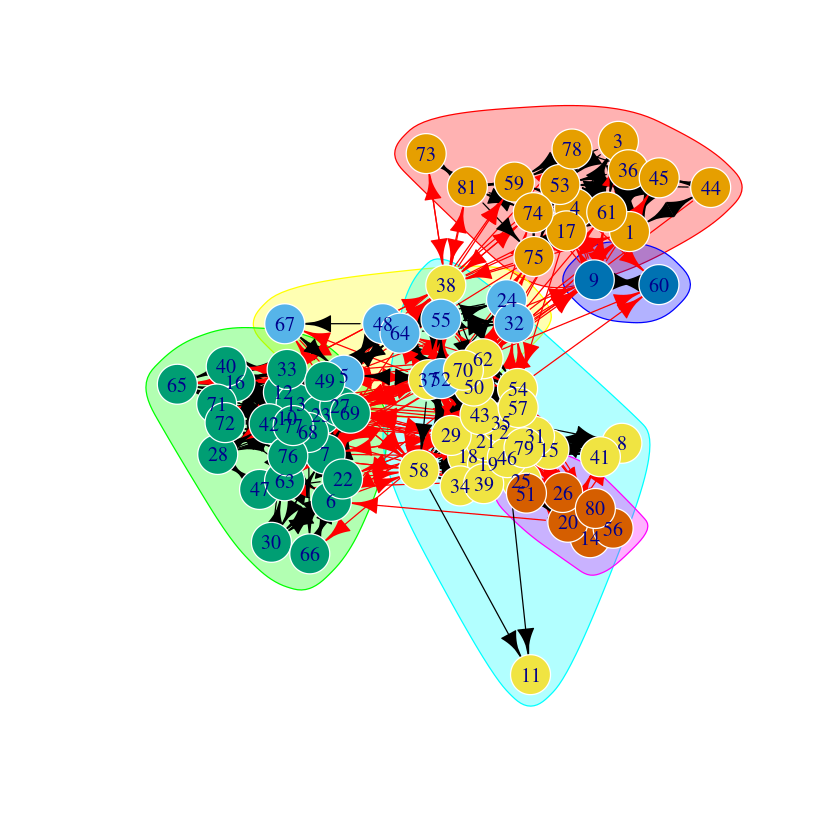

In [37]:
walk <- cluster_walktrap(UKfaculty)
plot(walk, UKfaculty)

Colors of the edges: by default the edges **within communities** are colored **black** and other edges are red.

### Modularity

Imagine a network $G = (V, E)$ where each node $i$ have a class $c_i$ (consider a finite number of classes $1, \dots, k$ and indicate the partition with $\mathcal{C}$). 
Compute the fraction of edges linking nodes of the same type (class)
$$\sum_{(i, j) \in E} \delta(c_i, c_j) = \frac12 \sum_{i, j} A_{ij} \delta(c_i, c_j)$$
with $\delta(c_i, c_j) = 1$ if $c_i = c_j$ that is nodes $i$ and $j$ have the same class and $\delta(c_i, c_j) = 0$ otherwise.

We say that the network is **assortative** if this fraction of nodes is "higher than expected" if egdes are placed at random$^1$. In the framework of social networks **homophily** or **assortative mixing** is precisely the tendency of people to associate with others with similar characteristics (nationality, language, gender...).

The opposite, disassortative mixing is more rare, but an example is mixing by gender in sexual contact.

From assortative mixing we get the **modularity** 
$$Q = Q(G, \mathcal{C}) = \frac{1}{2|E|} \sum_{i, j} \left( A_{ij} -\frac{k_i k_j}{2|E|} \right) \qquad (*)$$ 
another measure of the extent to which _like is connected to like_. 

#### Bounds

> **Lemma.** Let $G = (V, E)$ be an undirected and unweighted graph then $-\frac{1}{2} \leq Q(G, \mathcal{C}) \leq 1$

Maximum modularity is achieved if $ \delta(c_i, c_j) = 1$ whenever $A_{ij} = 1$ and from equation $(*)$ we can get a $Q_{max}$ value which is very useful for normalisation.

$Q > 1$ if the edge density between members of the same class is higher than edge density intra-communities, otherwise $Q < 1$.

$Q = \frac12$ for any complete bipartite graph $K_{n_1, n_2}$

##### Reference for proofs
[On Modularity Clustering - U. Brandes et al.(2009)](http://www.uni-konstanz.de/algo/publications/bdgghnw-mc-08.pdf)

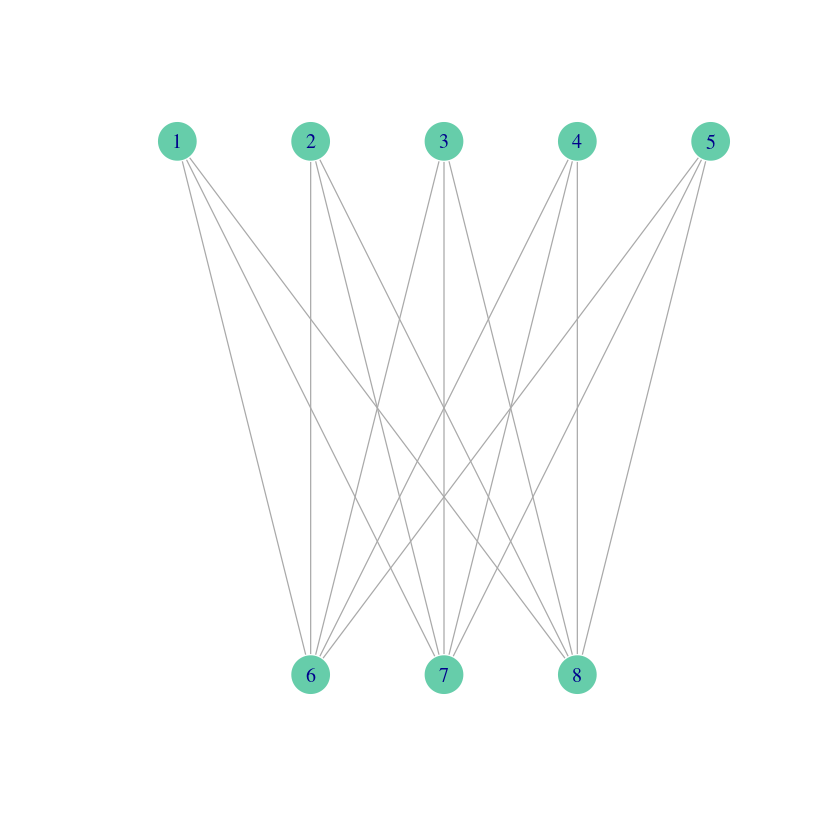

In [38]:
k_53 <- make_full_bipartite_graph(n1 = 5, n2 = 3)
plot(k_53, layout = layout_as_bipartite)

In [39]:
modularity(x = k_53, membership = (V(k_53)$type + 1))

[1] -0.5

Observe that we can compute the modularity of the given graph, providing the membership of each node, i.e. $c_i$. The classes (communities) are numbered starting from 1, while the vertex attribute `type` of the bipartite graph takes value $\{0, 1\}$, this is the reason why I put a `+ 1` in `membership = (V(k_53)$type + 1)`.

We can also compute the modularity of a given community object returned by `igraph`, for instance $Q(G, \mathcal{C}_{walktrap})$

In [40]:
modularity(walk)

[1] 0.5578907

Modularity Optimisazion
---
[Finding community structure in very large networks - A. Clauset, M. E. J. Newman, C. Moore](http://www.arxiv.org/abs/cond-mat/0408187)

* Hierarchical agglomeration algorithm for detecting community structure

$\, ^1$
    It is very common in network science to compare real networks with random graphs or, in general, null models to get the significance of the observed characteristics ~ statistical properties of the graph.

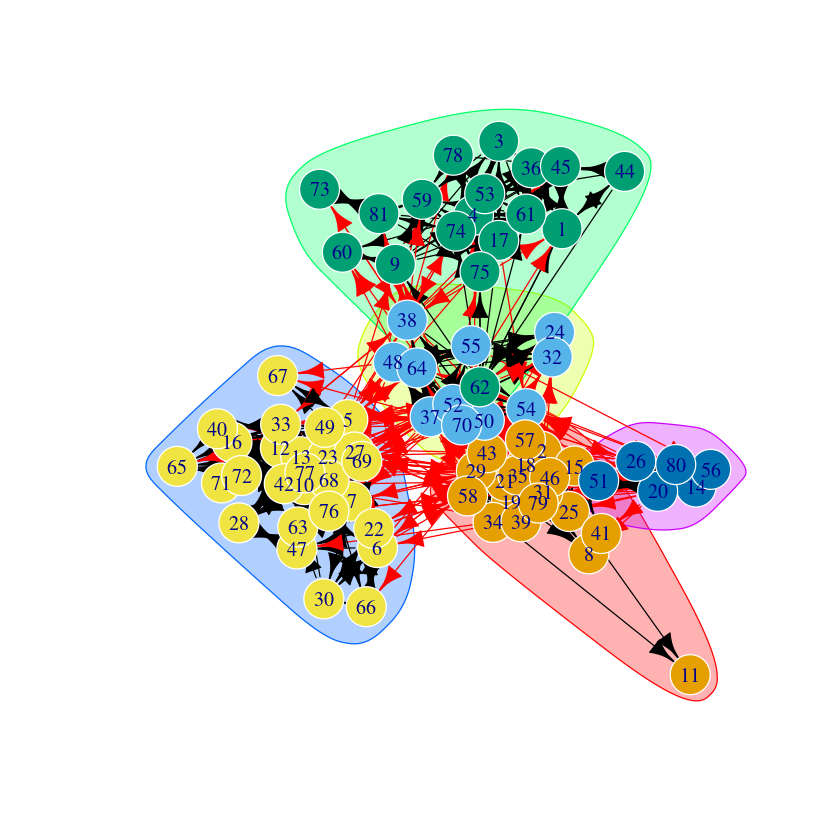

In [41]:
fgc <- cluster_fast_greedy(as.undirected(UKfaculty))
plot(fgc, UKfaculty)

In [42]:
modularity(fgc)

[1] 0.5622017

#### Finding community structure by multi-level optimization of modularity

[Fast unfolding of communities in large networks - V. Blondel et al. (2008)](https://arxiv.org/abs/0803.0476)

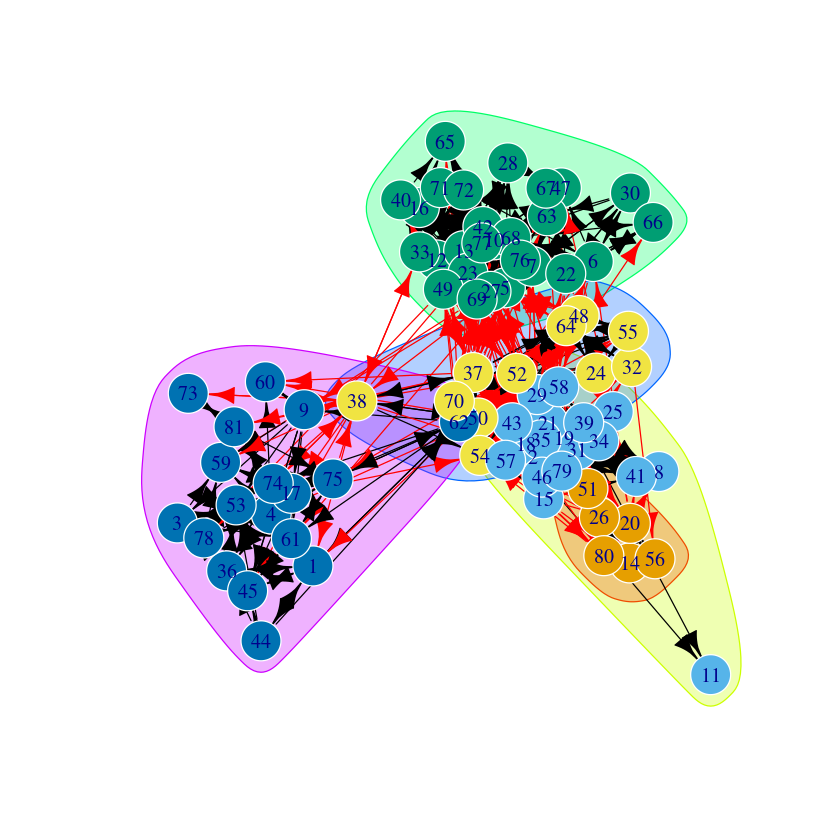

In [43]:
cll <- cluster_louvain(as.undirected(UKfaculty))
plot(cll, UKfaculty)

In [44]:
modularity(cll)

[1] 0.5622017

In [45]:
is_hierarchical(cll)

[1] FALSE

### Community detection in the karate club network

* Karate club network is often use as a toy model for community detection, since the _ground truth_ is available (the real split of the network)

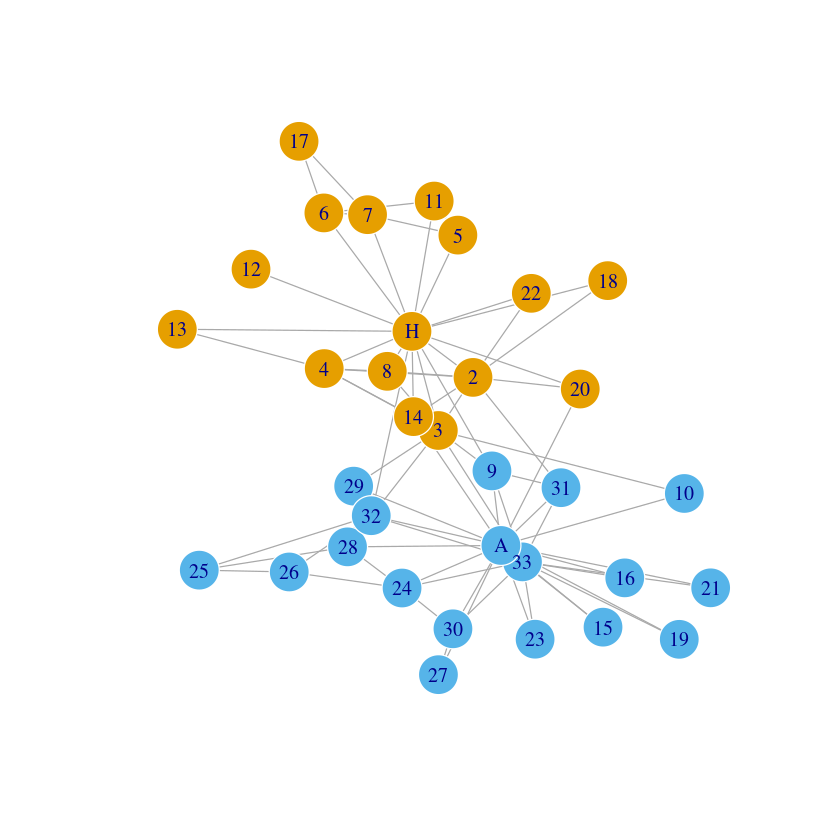

In [46]:
data(karate)
plot(karate)

In [47]:
fgc <- cluster_fast_greedy(karate)

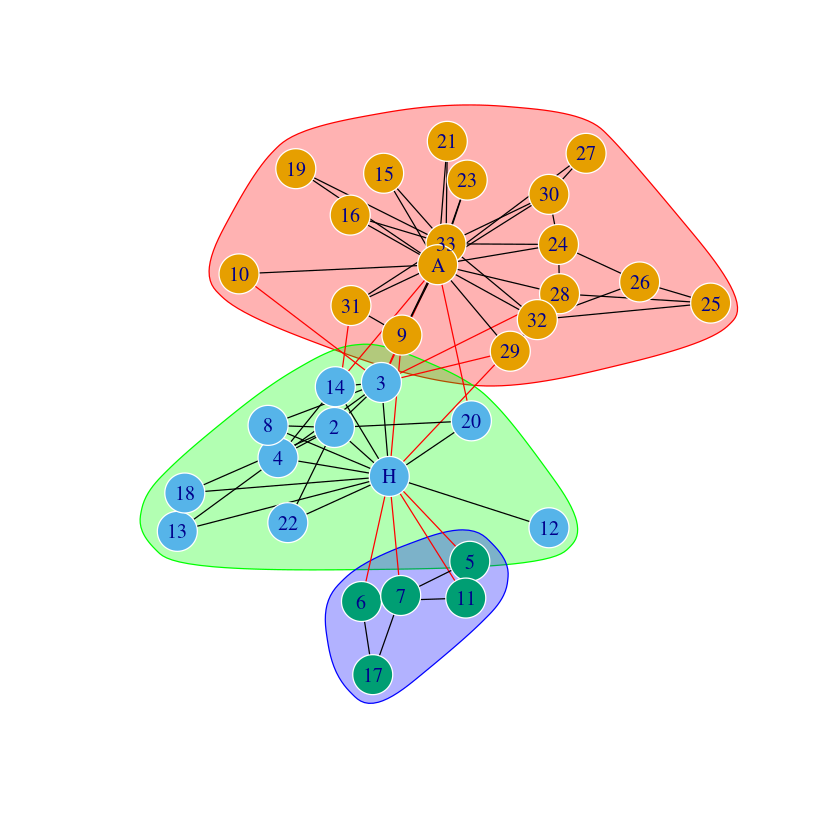

In [48]:
plot(fgc, karate)

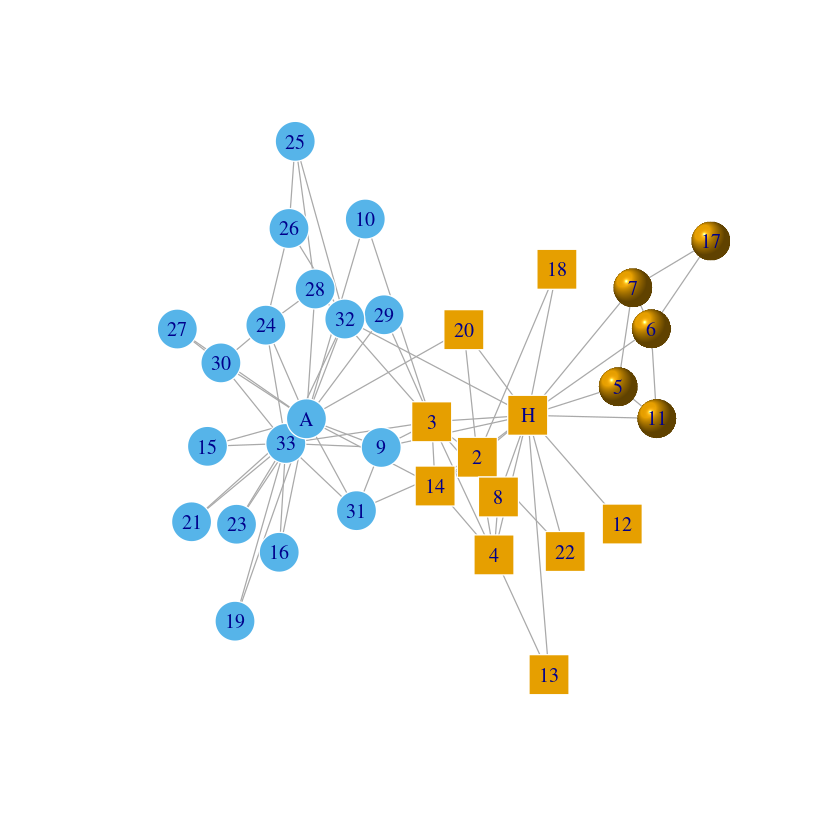

In [49]:
plot(karate, 
     vertex.shape = c("circle", "square", "sphere", "none")[fgc$membership])

In [50]:
library(readxl)

In [51]:
nodes <- read_excel("data/Dunne2013PBioSupData.xlsx", sheet = 2, skip = 1)
data <- read_excel("data/Dunne2013PBioSupData.xlsx", sheet = 3)

New names:
* ID -> ID..1
* Type -> Type..2
* Name -> Name..3
* `` -> `..4`
* ID -> ID..5
* … and 22 more
New names:
* `` -> `..2`
* `` -> `..3`
* `` -> `..5`
* `` -> `..6`
* `` -> `..8`


In [52]:
head(data)

FalsFree.web,..2,..3,FalsPar.web,..5,..6,FalsParCon.web,..8
18,2,NA,18,2,NA,18,2
18,5,NA,18,5,NA,18,5
19,2,NA,19,2,NA,19,2
19,10,NA,19,10,NA,19,10
20,2,NA,20,2,NA,20,2
20,10,NA,20,10,NA,20,10


In [53]:
data <- data[, 4:5]
data <- data[complete.cases(data), ]

In [54]:
head(data)

FalsPar.web,..5
18,2
18,5
19,2
19,10
20,2
20,10


In [55]:
nodes <- nodes[, 1:3]
colnames(nodes) <- c("id", "type", "name")
nodes <- nodes[complete.cases(nodes), ]

In [56]:
head(nodes)

id,type,name
1,1,carrion-detritus
2,1,marine-detritus
3,1,terrestrial-detritus
4,1,Saltwort
5,1,epipellic flora
6,1,Alkali Heath


In [57]:
dim(unique(data[ , 1]))

[1] 154   1

In [58]:
dim(nodes)

[1] 171   3

In [59]:
tail(nodes)

id,type,name
166,2,neme-long
167,2,cystacanth-pachygrapsus
168,2,cystacanth-fish b.cav
169,2,Ceratothoa sp.
170,2,Leidya sp.
171,2,Lironeca californica


In [60]:
g <- graph_from_data_frame(d = data, vertices = nodes)

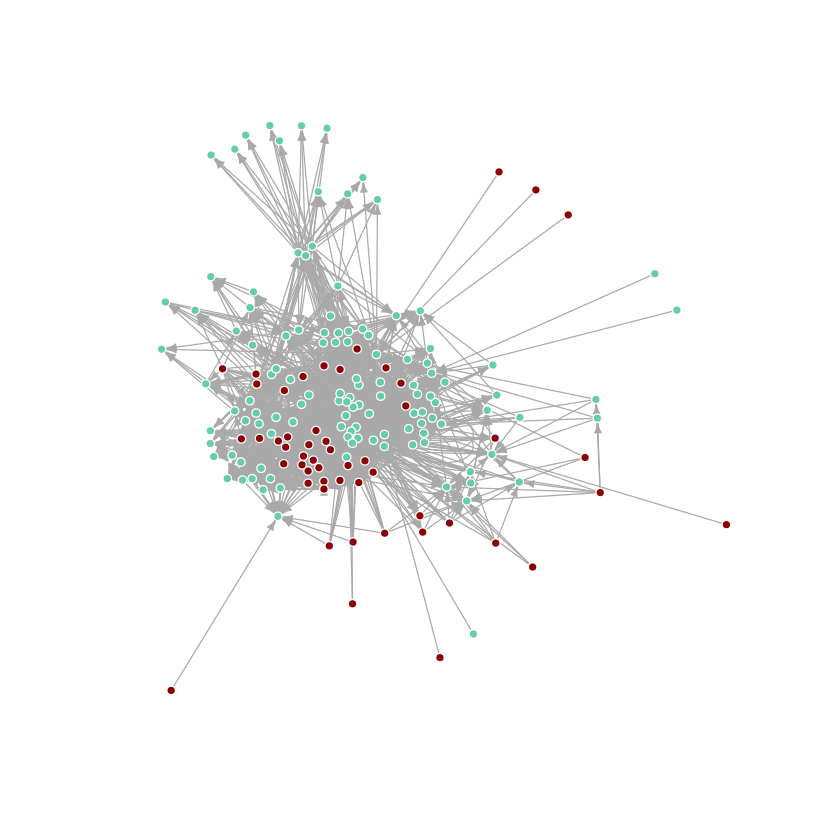

In [61]:
plot(g, vertex.label = "", vertex.size = 3, edge.arrow.size = .4,
     vertex.color = c("aquamarine3", "darkred")[V(g)$type])

In [62]:
cll <- cluster_louvain(as.undirected(g))

In [63]:
cll$modularity

[1] 0.2638895 0.2641366

In [64]:
unique(cll$membership)

[1] 3 2 1 5 4

We use the code from `igraph` documentation in order to have some custom shapes (triangles and stars in particular).
I added some small changes in order to have the same `veretx.frame.color`.

In [65]:
# triangle vertex shape
# code from igraph::add_shape 
#https://igraph.org/r/doc/shapes.html
# ---
mytriangle <- function(coords, v = NULL, params) {
  vertex.color <- params("vertex", "color")
  if (length(vertex.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.color[v]
  }
  vertex.frame.color <- params("vertex", "frame.color")
  if (length(vertex.frame.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.frame.color[v]
  }
  vertex.size <- 1/200 * params("vertex", "size")
  if (length(vertex.size) != 1 && !is.null(v)) {
    vertex.size <- vertex.size[v]
  }
    # check how to pass parameter to symbol function
  symbols(x = coords[, 1], y = coords[, 2], bg = vertex.color,
          stars = cbind(vertex.size, vertex.size, vertex.size),
          add = TRUE, inches = FALSE)
}
# clips as a circle
add_shape("triangle", clip = shapes("circle")$clip,
          plot = mytriangle)
# idem for star shape
# generic star vertex shape, with a parameter for number of rays
mystar <- function(coords, v=NULL, params) {
  vertex.color <- params("vertex", "color")
  if (length(vertex.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.color[v]
  }
  vertex.frame.color <- params("vertex", "frame.color")
  if (length(vertex.frame.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.frame.color[v]
  }
  vertex.size  <- 1/200 * params("vertex", "size")
  if (length(vertex.size) != 1 && !is.null(v)) {
    vertex.size <- vertex.size[v]
  }
  norays <- params("vertex", "norays")
  if (length(norays) != 1 && !is.null(v)) {
    norays <- norays[v]
  }

  mapply(coords[, 1], coords[, 2], vertex.color, vertex.frame.color, vertex.size, norays,
         FUN = function(x, y, bg, size, nor) { # check how to pass parameter to symbol function
           symbols(x=x, y=y, bg=bg,
                   stars=matrix(c(size,size/2), nrow=1, ncol=nor*2),
                   add=TRUE, inches=FALSE)
         })
}
# no clipping, edges will be below the vertices anyway
add_shape("star", clip = shape_noclip,
          plot = mystar, parameters = list(vertex.norays = 5))

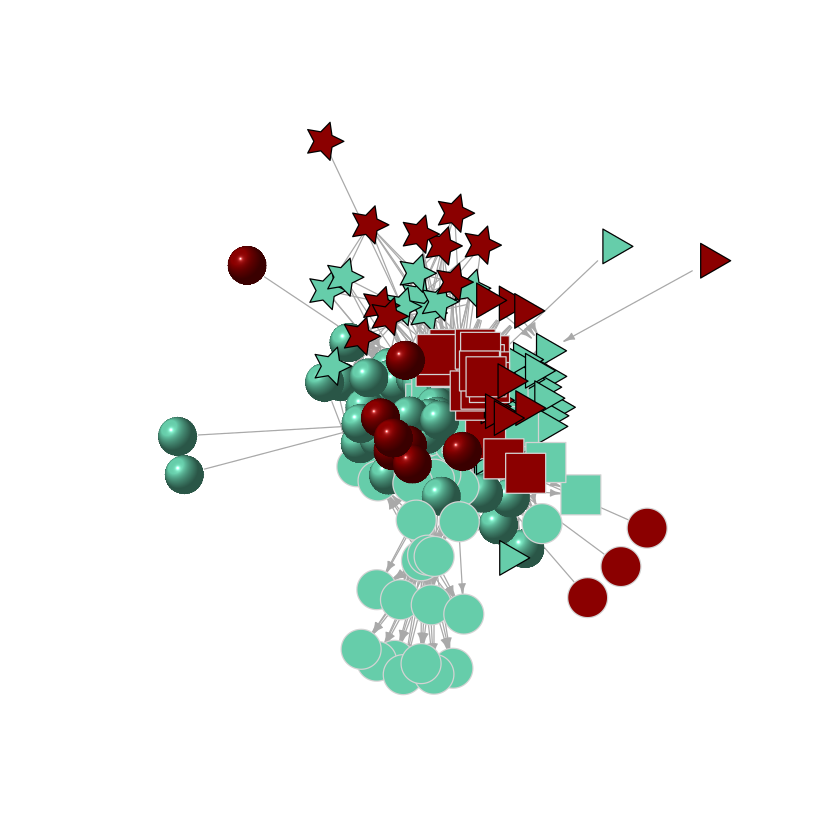

In [66]:
plot(g, vertex.label = "", edge.arrow.size = .4, vertex.frame.color = "lightgray",
     vertex.color = c("aquamarine3", "darkred")[V(g)$type], 
     vertex.shape = c("circle", "sphere", "rectangle", "star", "triangle")[cll$membership])

In [67]:
fgc <- cluster_walktrap(g)
modularity(fgc)
unique(fgc$membership)

[1] 0.06231311

[1]  9  8  7 16 17 18 11 19  6 20 21 22 23 24 25 26  5 27 28 29 14  4 30  1 15
[26] 13  3 31  2 12 10 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46

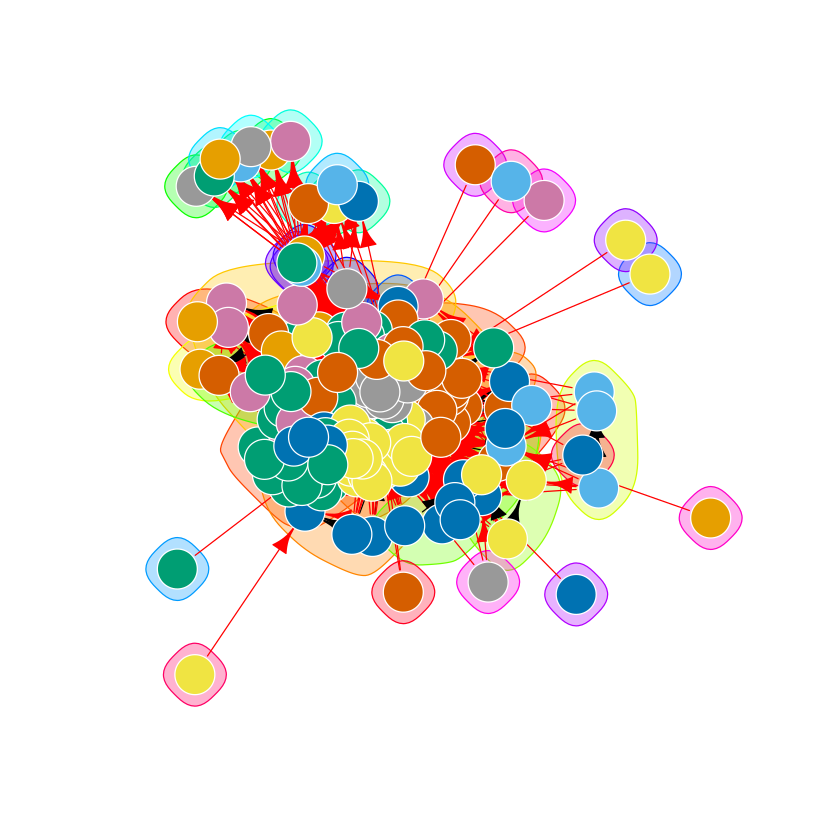

In [68]:
plot(fgc, g, vertex.label = "", vertex.color = V(g)$type)

In [69]:
plot(g, vertex.label = "", edge.arrow.size = .4,
     vertex.color = c("aquamarine3", "darkred")[V(g)$type], 
     vertex.shape = c("circle", "rectangle")[fgc$membership])

ERROR: Error in igraph.check.shapes(params("vertex", "shape")): Bad vertex shape(s): NA.


### References:
[Networ Viz](http://kateto.net/network-visualization)